<a href="https://colab.research.google.com/github/ellieytc/CaseStudy.DeepLearning/blob/master/Food_ResNet50_0_93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Aug 19 20:33:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Library

In [2]:
import numpy as np 
import pandas as pd 

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

## Download Data

In [3]:
import os
import zipfile
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Tibame/dataset/food_imgtt.zip'

zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

os.chdir('/tmp')
os.listdir('/tmp')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


['tmpvkaackea',
 'drivefs_ipc.0_shell',
 'food_train',
 'food_test',
 'sampleSubmission.csv',
 'drivefs_ipc.0']

## Prepare Training Data

In [4]:
filenames = os.listdir('/tmp/food_train/')
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'apple':
      categories.append(0)
    elif category == 'cabbage':
      categories.append(1)
    elif category == 'carrot':
      categories.append(2)
    elif category == 'chicken':
      categories.append(3)
    elif category == 'cucumber':
      categories.append(4)
    elif category == 'egg':
      categories.append(5)
    elif category == 'mushroom':
      categories.append(6)
    elif category == 'potato':
      categories.append(7)
    elif category == 'radish':
      categories.append(8)       
    else:
      categories.append(9)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
}, dtype=str)
df.head()

,filename,category
0,cabbage_209.jpg,1
1,chicken_30.jpg,3
2,cucumber_257.jpg,4
3,tomato_582.jpg,9
4,egg_952.jpg,5


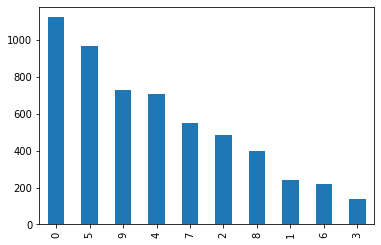

In [5]:
df['category'].value_counts().plot.bar()

## See sample image

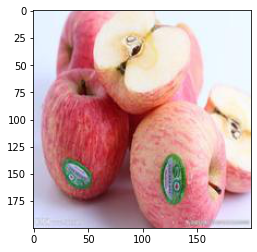

In [6]:
sample = random.choice(filenames)
image = load_img('/tmp/food_train/' + sample)
plt.imshow(image)

## Build Model

In [50]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.applications.resnet50 import ResNet50
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Model
import keras

image_size = 200
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
pre_trained_model = ResNet50(include_top=False, 
                weights='imagenet',
                input_tensor=None,
                input_shape=input_shape)

x = pre_trained_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(10, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
model = Model(inputs=pre_trained_model.input, outputs=output_layer)
for layer in pre_trained_model.layers[:2]:
    layer.trainable = False
for layer in pre_trained_model.layers[2:]:
    layer.trainable = True

model.compile(loss='categorical_crossentropy',
       optimizer=optimizers.Adam(lr=1e-5),
          metrics=['accuracy'])

model.summary()


94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
______________________

## Prepare Test and Train Data

In [51]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

## Training Generator

In [52]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    '/tmp/food_train/', 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 4995 validated image filenames belonging to 10 classes.


## Validation Generator

In [53]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    '/tmp/food_train/', 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 555 validated image filenames belonging to 10 classes.


## See sample generated images

Found 1 validated image filenames belonging to 1 classes.


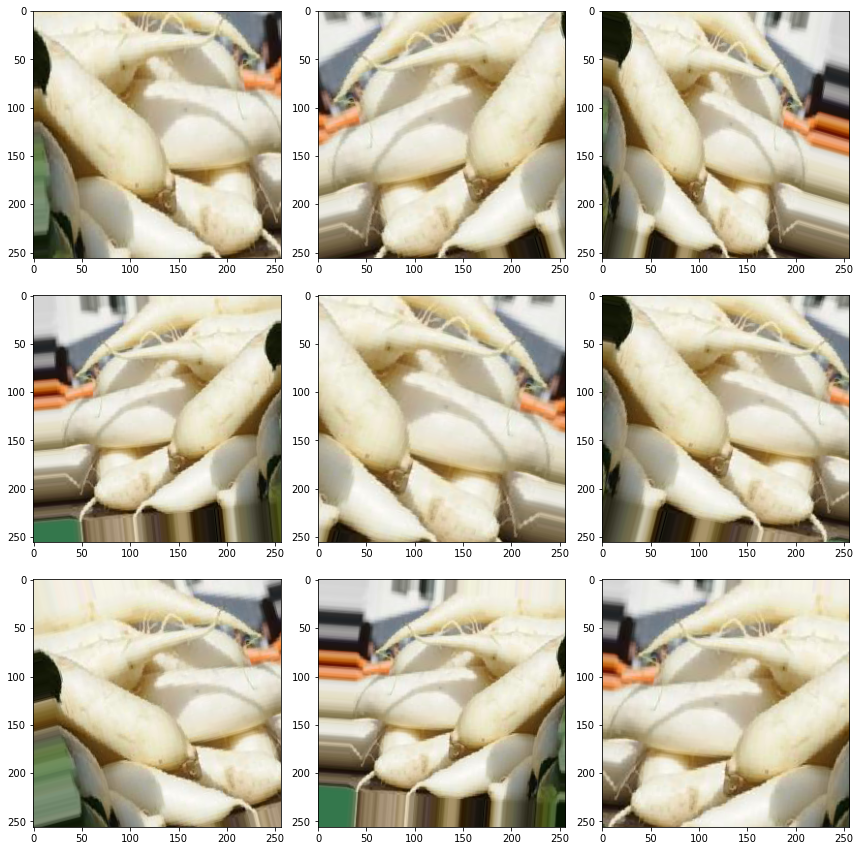

In [54]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    '/tmp/food_train/', 
    x_col='filename',
    y_col='category',
    class_mode='categorical'
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [55]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [56]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/5
312/312 [==============================] - 61s 196ms/step - loss: 1.0529 - accuracy: 0.7982 - val_loss: 6.5961 - val_accuracy: 0.0754
Epoch 2/5
312/312 [==============================] - 60s 191ms/step - loss: 0.4444 - accuracy: 0.9148 - val_loss: 3.9226 - val_accuracy: 0.3860
Epoch 3/5
312/312 [==============================] - 59s 191ms/step - loss: 0.3084 - accuracy: 0.9393 - val_loss: 0.5371 - val_accuracy: 0.9191
Epoch 4/5
312/312 [==============================] - 59s 188ms/step - loss: 0.2217 - accuracy: 0.9544 - val_loss: 0.2309 - val_accuracy: 0.9632
Epoch 5/5
312/312 [==============================] - 59s 190ms/step - loss: 0.1607 - accuracy: 0.9645 - val_loss: 0.3832 - val_accuracy: 0.9375


In [57]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test: accuracy = 0.937500  ;  loss = 0.383069 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


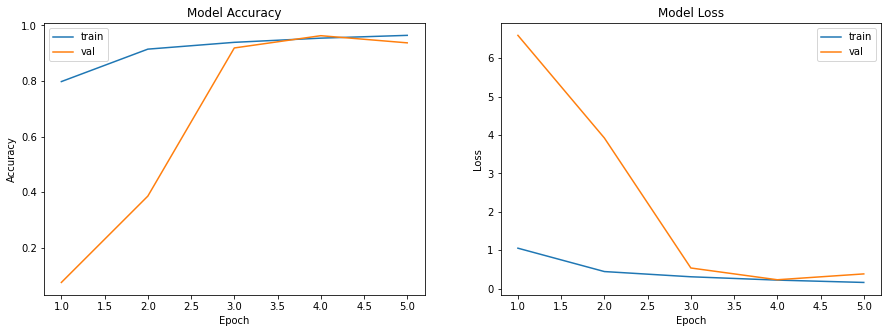

In [58]:
def plot_model_history(model_history, accuracy='accuracy', val_accurary='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[accuracy])+1),model_history.history[accuracy])
    axs[0].plot(range(1,len(model_history.history[val_accurary])+1),model_history.history[val_accurary])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[accuracy])+1),len(model_history.history[accuracy])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [59]:
Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [60]:
y_final = np.argmax(y_pred, axis=1)
y_final.size

555

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


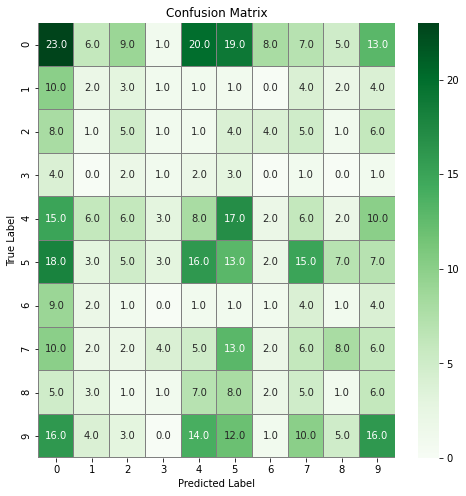

In [61]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val.astype(str), y_final.astype(str)) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [62]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val.astype(str), y_final.astype(str), target_names=['0','1','2','3','4','5','6','7','8','9'])

print(report)

              precision    recall  f1-score   support

           0       0.19      0.21      0.20       111
           1       0.07      0.07      0.07        28
           2       0.14      0.14      0.14        36
           3       0.07      0.07      0.07        14
           4       0.11      0.11      0.11        75
           5       0.14      0.15      0.14        89
           6       0.05      0.04      0.04        24
           7       0.10      0.10      0.10        58
           8       0.03      0.03      0.03        39
           9       0.22      0.20      0.21        81

    accuracy                           0.14       555
   macro avg       0.11      0.11      0.11       555
weighted avg       0.14      0.14      0.14       555



## Prepare Testing Data

In [63]:
test_filenames = os.listdir('/tmp/food_test/')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Create Testing Generator

In [64]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    '/tmp/food_test/', 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 1422 validated image filenames.


## Predict

In [65]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
test_df['category'] = np.argmax(predict, axis=1)

## See predicted result

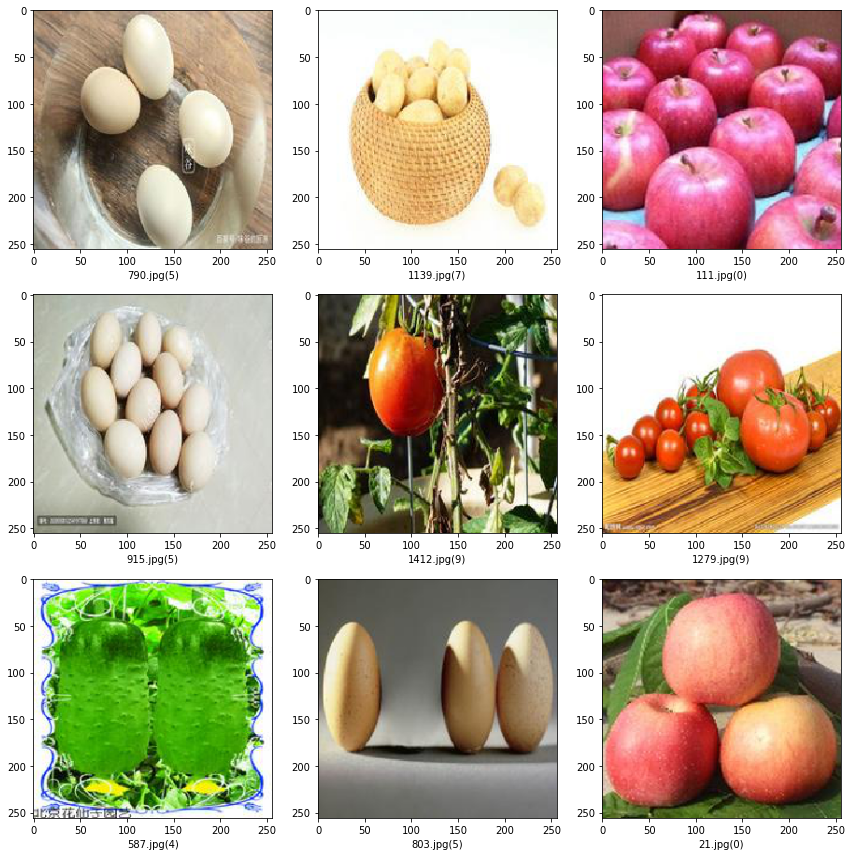

In [66]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('/tmp/food_test/' + filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

## Submission

Text(0.5, 1.0, '(Test data)')

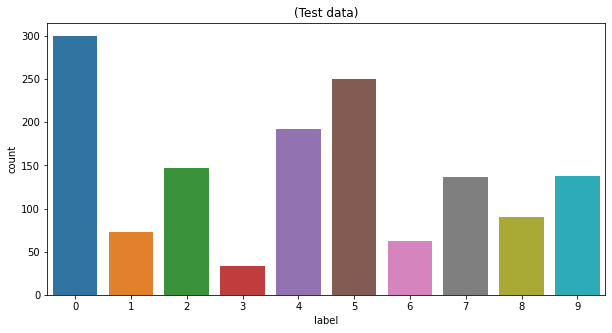

In [67]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_13010030.csv', index=False)

plt.figure(figsize=(10,5))
sns.countplot(submission_df['label'])
plt.title("(Test data)")